In [1]:
from glob import glob
import json
import os
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
report_files = glob('tacc_models/reports/*.json')
print(f"Number of report files: {len(report_files)}")

Number of report files: 708


In [3]:
protein_to_uniprot = json.load(open('protein_to_uniprot.json', 'r'))
uniprot_to_protein = json.load(open('uniprot_to_protein_name.json', 'r'))

In [4]:
# archive_dir = 'archive'
# tacc_dir = 'tacc_models'
# model_dir = os.path.join(tacc_dir, 'models')
# report_dir = os.path.join(tacc_dir, 'reports')
# # #shutil.os.mkdir(archive_dir)

In [5]:
# for r in report_files:
#     _dir, _file = os.path.split(r)
#     _model_name = os.path.splitext(_file)[0][:6]
#     if _model_name not in protein_to_uniprot.values():
#         print(_model_name)
#         _model_name = os.path.splitext(_file)[0][:-8]
#         uniprot_id = protein_to_uniprot[_model_name]
#         print(r, _dir, _file, _model_name)
#         # copy report file
#         shutil.copy2(r, archive_dir)
#         # rename report file
#         shutil.move(r, os.path.join(report_dir, f"{uniprot_id}_results.json"))
#         # copy model files
#         for types in ['.xgb', '.rf', '.mlp', '.svc']:
#             src_file = os.path.join(model_dir, f"{_model_name}{types}")
#             dest_file = os.path.join(archive_dir)
#             shutil.copy2(src_file, dest_file)
#             # rename
#             shutil.move(src_file, os.path.join(model_dir, f"{uniprot_id}{types}"))
#             print(src_file, dest_file, uniprot_id)
#         print(protein_to_uniprot[_model_name])
#     #break

In [6]:
model_names= []

In [13]:
metrics = ['accuracy', 'f1_score', 'cohen_kappa', 'mcc']
models = ['xgb', 'rf', 'svc', 'mlp']
data_metrics = ['train_count', 'test_count', 'actives_count', 'decoys_count']
report = dict()

for _file in report_files:
    # Strip the model name
    _dir, _model_name = os.path.split(_file)
    model_name = os.path.splitext(_model_name)[0][:6]
    
    # Load the dictionary
    _dict = json.load(open(_file, 'r'))
    #model_name = _dict['xgb']['uniprot_id']
    model_names.append(model_name)
    
    # Extract the metrics
    _report = [round(_dict[model][metric], 4) for model in models for metric in metrics]
    
    # Find the best model
    # Use cohen kappa, if not available then use f1 score
    scores = np.array([_dict[model]['cohen_kappa'] for model in models])
    best_metric = 'cohen_kappa'
    if 0 in scores:
        scores = np.array([_dict[model]['f1_score'] for model in models])
        best_metric = 'f1_score'
        
    best_model = models[np.argmax(scores)]
    best_score = round(np.max(scores), 4)
    _data_info = [_dict['xgb']['data_info'][c] for c in data_metrics]
    report[model_name] = _report + _data_info + [best_model, best_metric, best_score]
    #break

report_df = pd.DataFrame.from_dict(report, orient='index')
report_df.columns = [f"{model}_{metric}" for model in models for metric in metrics] + data_metrics + ['best_model', 'best_metric', 'best_score']

In [14]:
report_df.head(10)

,xgb_accuracy,xgb_f1_score,xgb_cohen_kappa,xgb_mcc,rf_accuracy,rf_f1_score,rf_cohen_kappa,rf_mcc,svc_accuracy,svc_f1_score,...,mlp_f1_score,mlp_cohen_kappa,mlp_mcc,train_count,test_count,actives_count,decoys_count,best_model,best_metric,best_score
P12268,0.9971,0.9971,0.9825,0.9826,0.9981,0.9981,0.9884,0.9884,0.9981,0.9981,...,0.9981,0.9884,0.9884,4180,1045,475,4750,rf,cohen_kappa,0.9884
Q96RJ0,0.9748,0.9730,0.8288,0.8412,0.9580,0.9523,0.6854,0.7220,0.9832,0.9838,...,0.9730,0.8288,0.8412,475,119,54,540,svc,cohen_kappa,0.9074
P11387,0.9962,0.9961,0.9211,0.9240,0.9981,0.9981,0.9620,0.9627,0.9981,0.9981,...,0.9961,0.9211,0.9240,4203,1051,142,5112,svc,cohen_kappa,0.9645
P48443,0.9928,0.9927,0.9561,0.9570,0.9928,0.9927,0.9561,0.9570,1.0000,1.0000,...,1.0000,1.0000,1.0000,554,139,63,630,svc,cohen_kappa,1.0000
Q03181,0.9948,0.9947,0.9677,0.9678,0.9974,0.9974,0.9839,0.9840,0.9908,0.9909,...,0.9839,0.9005,0.9016,3044,762,346,3460,rf,cohen_kappa,0.9839
Q13946,0.9866,0.9862,0.9139,0.9164,0.9918,0.9916,0.9479,0.9492,0.9846,0.9848,...,0.9948,0.9679,0.9684,3880,971,441,4410,mlp,cohen_kappa,0.9679
Q01432,0.9730,0.9596,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,740,185,25,900,rf,f1_score,1.0000
P08581,0.9971,0.9971,0.9822,0.9822,0.9956,0.9956,0.9732,0.9733,0.9964,0.9964,...,0.9975,0.9847,0.9847,10973,2744,1247,12470,mlp,cohen_kappa,0.9847
P07384,0.9903,0.9901,0.9391,0.9401,0.9988,0.9988,0.9926,0.9926,0.9939,0.9940,...,0.9928,0.9565,0.9566,3300,825,375,3750,rf,cohen_kappa,0.9926
P34903,0.9735,0.9604,0.0000,0.0000,0.9912,0.9903,0.7957,0.8128,0.9889,0.9887,...,0.9846,0.6607,0.7023,1805,452,61,2196,rf,f1_score,0.9903


In [15]:
len(report_df)

708

In [16]:
report_df.to_csv('Report.csv')

best_model
mlp    124
rf     263
svc    165
xgb    156
dtype: int64


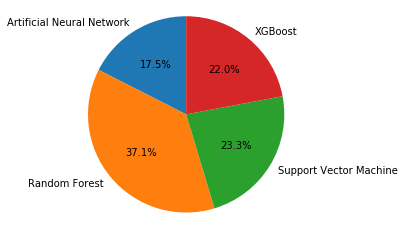

In [17]:
count = report_df.groupby('best_model').size()
print(count)
fig1, ax1 = plt.subplots()
ax1.pie(count, 
        autopct = '%1.1f%%',
        startangle = 90,
        labels = ['Artificial Neural Network', 'Random Forest', 'Support Vector Machine', 'XGBoost'])
ax1.axis('equal')
plt.savefig('model_pie', dpi=300)
plt.show()

In [18]:
report_df.groupby('best_metric').size()

best_metric
cohen_kappa    572
f1_score       136
dtype: int64

In [19]:
import mysql.connector as sql

In [35]:
db_connection = sql.connect(host='129.108.3.163', db='tcrd544', user='tcrd', password='tcrd')
query = "SELECT id, name, description, uniprot, seq, sym \
         FROM protein"
protein_df = pd.read_sql(query, con=db_connection)
protein_df = protein_df.set_index('id')
query = "SELECT id, name, tdl, fam, famext \
         FROM target"
target_df = pd.read_sql(query, con=db_connection)
target_df = target_df.set_index('id')
db_connection.close()

In [37]:
protein_df = protein_df[protein_df.uniprot.isin(report_df.index)][['name', 'uniprot', 'sym']]
protein_df.head()

,name,uniprot,sym
id,,,
42,ACM1_HUMAN,P11229,CHRM1
59,ADA10_HUMAN,O14672,ADAM10
61,ADA17_HUMAN,P78536,ADAM17
63,ADA1D_HUMAN,P25100,ADRA1D
67,ADA2A_HUMAN,P08913,ADRA2A


In [40]:
pd.merge(protein_df, target_df, on='uniprot')

KeyError: 'uniprot'